### Implementation of the efficient algorithm for generating ROC points
- Algorithm 1 in paper by *Fawcett 2006*

In [1]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
def ROC_points(in_data):
    '''
    Function to generate ROC points for a bianry classifier on a given sample set with true lables and scores
    Input: a DataFrame with actual class label and scores
    Output:ROC points (tp rate, fp rate)
    '''
    ## sort the input data in descending order
    dat=in_data.sort_values(by=['score'],ascending=False)
    ## compute # of positive labels and negative labels
    P=dat.label[dat.label==1].count()
    N=dat.label[dat.label==0].count()
    
    ## initialize tp and fp to 0
    tp=0
    fp=0
    ## initialize previous score to -inf
    f_prev=-np.inf
    
    ## create an empty stack
    result=[]
    
    ## compute ROC points increasing by fp rate
    for i in range(dat.shape[0]):
        if dat.score[i]!=f_prev:
            result.append((fp/N,tp/P))
            f_prev=dat.score[i]
        if dat.label[i]==1:
            tp+=1
        else:
            fp+=1
    result.append((fp/N,tp/P))
    
    return pd.DataFrame(result,columns=['fp','tp'])

- Apply the function ROC_points onto a test data set (Figure 3 in paper by Fawcett)

In [3]:
# test sample
# Figure 3 in Fawcett 2006
# class label=1: positive, label=0: negative
instance=np.array(range(20))
class_lable=np.array([1,1,0,1,1,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0])
score_=np.array([0.9,0.8,0.7,0.6,0.55,0.54,0.53,0.52,0.51,0.505,0.4,0.39,0.38,0.37,0.36,0.35,0.34,0.33,0.30,0.1])
temp={'ID':instance,'label':class_lable,'score':score_}

# put them together as a DataFrame
dat_test=pd.DataFrame(data=temp,index=range(len(instance)),columns=['ID','label','score'])


In [4]:
# shuffle the order
ind=np.random.choice(range(len(instance)),size=len(instance),replace=False)
dat_test=dat_test.iloc[ind]

In [6]:
#ind_order=np.argsort()
dat_test.sort_values(by=['score'],ascending=False).head()

,ID,label,score
0,0,1,0.90
1,1,1,0.80
2,2,0,0.70
3,3,1,0.60
4,4,1,0.55


In [7]:
# apply the function on the above test data set
points=ROC_points(dat_test)
# inspect the output value
points.head()

,fp,tp
0,0.0,0.0
1,0.0,0.1
2,0.0,0.2
3,0.1,0.2
4,0.1,0.3


### Plot the computed ROC curve for a result of a classifier

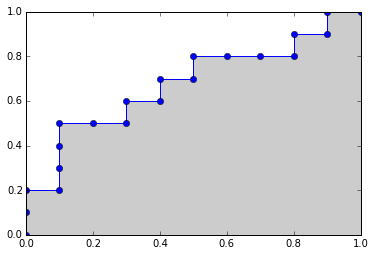

In [8]:
fig, ax = plt.subplots()
# plot the roc curve
plt.plot(points.fp,points.tp,'o-')
# shape the area under curve
verts =  [(points.fp[0], 0)]+list(zip(points.fp,points.tp))+[(points.fp[len(points.fp)-1], 0)]
poly = plt.Polygon(verts, facecolor='0.8', edgecolor='0.5')
ax.add_patch(poly)

### Define a function to plot any set of ROC points with the area under the curved shaded. 
- The 45 degree line is plotted in red. A classifier does random guessing will generate a ROC curve lined up with the 45 degree line

In [9]:
def roc_graph(input_rates,title=''):
    '''
    Function to plot the ROC curve and the shaded the area under the curve
    input rates: the ROC points of a classification result
    return: None, plot is generated
    '''
    # import necessary packages
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    points=input_rates
    
    fig, ax = plt.subplots()
    # plot the roc curve
    plt.plot(points.fp,points.tp,'o-')
    
    # set axis labels and title
    plt.xlabel('False positive rate',fontsize=15)
    plt.ylabel('True positive rate',fontsize=15)
    plt.title(title,fontsize=20)
    
    # shape the area under curve
    verts =  [(points.fp[0], 0)]+list(zip(points.fp,points.tp))+[(points.fp[len(points.fp)-1], 0)]
    poly = plt.Polygon(verts, facecolor='0.8', edgecolor='0.5')
    ax.add_patch(poly)
    
    # plot the 45 degree line in red
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x,'r')

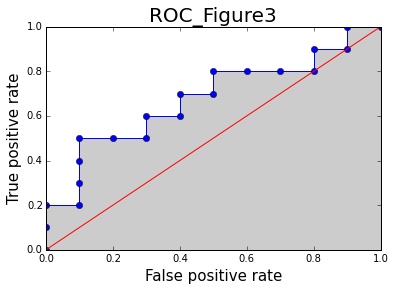

In [10]:
roc_graph(points,'ROC_Figure3')

### Calculate the area under an ROC curve (AUC)
- Algorithm 2 in paper by *Fawcett 2006*

In [166]:
def TRAPEZOID_AREA(x1,x2,y1,y2):
        '''
        Function to calculate the trapezoid area  
        Input: four vertex of the trapezoid 
        Output: the area of the trapezoid
        '''
        base = abs(x1-x2)
        height = (y1+y2)/2
        return base*height

In [167]:
def AUC(in_data):
    '''
    Function to calculate the area under an ROC curve 
    Input: a DataFrame with actual class label and scores
    Output: A, the area under the ROC curve. 0<A<1.0 
    '''
    ## sort the input data in descending order
    dat=in_data.sort_values(by=['score'],ascending=False)
    ## compute # of positive labels and negative labels
    P=dat.label[dat.label==1].count()
    N=dat.label[dat.label==0].count()
    
    ## initialize tp and fp to 0
    tp=0
    fp=0
    
    ## initialize previous tp and fp to -inf
    tp_prev=0
    fp_prev=0
    
    ## initialize the AUC score to 0
    A = 0
    
    ## initialize previous score to -inf
    f_prev=-np.inf
    
    ## compute ROC points increasing by fp rate
    for i in range(dat.shape[0]):
        if dat.score[i]!=f_prev:
            A += TRAPEZOID_AREA(fp,fp_prev,tp,tp_prev)
            f_prev = dat.score[i]
            fp_prev = fp
            tp_prev = tp
               
        if dat.label[i]==1:
            tp+=1
        else:
            fp+=1
    
    A = A+TRAPEZOID_AREA(N,fp_prev,N,tp_prev)
    A = A/(P*N) # scale from P · N onto the unit square
    
    return A

- Apply the function auc onto a test data set (Figure 3 in paper by Fawcett)

In [168]:
# test sample
# Figure 3 in Fawcett 2006
# class label=1: positive, label=0: negative
instance=np.array(range(20))
class_lable=np.array([1,1,0,1,1,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0])
score_=np.array([0.9,0.8,0.7,0.6,0.55,0.54,0.53,0.52,0.51,0.505,0.4,0.39,0.38,0.37,0.36,0.35,0.34,0.33,0.30,0.1])
temp={'ID':instance,'label':class_lable,'score':score_}

# put them together as a matrix
dat_test=pd.DataFrame(data=temp,index=range(len(instance)),columns=['ID','label','score'])

In [170]:
AUC(dat_test)

0.68000000000000005

## ROC curve averaging

When cross validation is done and clustering result of multiple test data sets are obtained, one might want to get a combined information on all the tested data sets-averaging multiple ROC curves. There are two ways of averaging multiple ROC curves:

- Verticle averaging: Algorithm 3 in paper by _Fawcett 2006_
- Threshold averaging: Algorithm 4 in paper by _Fawcett 2006_


### Verticle averaging
For a fixed false positive rate, find the maximum true postive rate or the interpolated true positive rate of every curve. The averagin is done by taking the mean of the true positive rate computed above for all ROC curves for any given false positive rate

In [15]:
def INTERPOLATE(ROCP1,ROCP2,X):
    '''
    Function to compute the slope for interpolation
    Input: two ROC curve points(ROCP1,ROCP2)
           X: target false postivie rate (FPR) 
    Return: The interpolated true positive rate for the given FPR
    '''
    
    slope=(ROCP2.tp-ROCP1.tp)/(ROCP2.fp-ROCP1.fp)
    return ROCP1.tp+slope*(X-ROCP1.fp)

In [16]:
def TPR_FOR_FPR(fpr_sample,ROC,npts):
    '''
    Function to find the largest true positive rate (TPR) for a given false positive rate (FPR)
    Input: fpr_sample (false positive rate fixed)
           ROC (a set of ROC points)
           npts(number of points in ROC)
    Output: The largest TPR or the interpolated TPR for the given FPR in a ROC curve
    '''
    i=1
    while(i<npts and ROC.fp[i] <= fpr_sample):
        i+=1
    
    if ROC.fp[i-1]==fpr_sample:
        return ROC.tp[i-1]
    else:
        return INTERPOLATE(ROC.ix[i-1],ROC.ix[i],fpr_sample)

In [17]:
def verticle_averaging(sample,ROCS,*karg):
    '''
    Function to compute the verticle averaging ROC points for input points of ROC curves
    Input:sample(number of false positive samples, the number of points along the x axis of the averaged ROC curve),
          ROCS(a list of multiple ROC curves, each curve is  stored in DataFrame and has 2 components:fp and tp)
    Output: the averaged ROC points
    '''

    # create an empty array to record result
    result=[]
    # number of roc cruves
    nrocs=len(ROCS)
    
    for fpr_sample in np.arange(0,(1+1/sample),1/sample):
        tprsum=0
        for i in range(nrocs):
            tprsum+=TPR_FOR_FPR(fpr_sample,ROCS[i],ROCS[i].shape[0])
        result.append((fpr_sample,tprsum/nrocs))
    #result.append((1,1))
    return pd.DataFrame(result,columns=['fp','tp'])

In [18]:
# create a test data set
# repeat points 3 times into a list
l1=[points,points,points]
for i in l1:
    print(i.shape)

(21, 2)
(21, 2)
(21, 2)


### computed the vertical averaging curve on the list of test data set
- 10 samples of false positive rates are considered

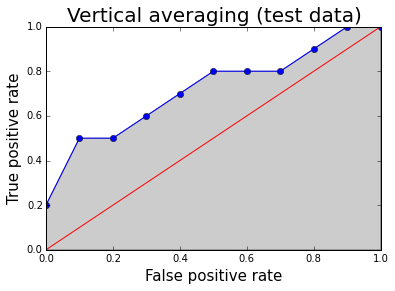

In [19]:
averaged_verticle=verticle_averaging(10,l1)
roc_graph(averaged_verticle,title='Vertical averaging (test data)')

In [20]:
# inspect the vertical averaged ROC points
print(points,"\n", averaged_verticle)

     fp   tp
0   0.0  0.0
1   0.0  0.1
2   0.0  0.2
3   0.1  0.2
4   0.1  0.3
5   0.1  0.4
6   0.1  0.5
7   0.2  0.5
8   0.3  0.5
9   0.3  0.6
10  0.4  0.6
11  0.4  0.7
12  0.5  0.7
13  0.5  0.8
14  0.6  0.8
15  0.7  0.8
16  0.8  0.8
17  0.8  0.9
18  0.9  0.9
19  0.9  1.0
20  1.0  1.0 
      fp   tp
0   0.0  0.2
1   0.1  0.5
2   0.2  0.5
3   0.3  0.6
4   0.4  0.7
5   0.5  0.8
6   0.6  0.8
7   0.7  0.8
8   0.8  0.9
9   0.9  1.0
10  1.0  1.0


### Threshold averaging 

- when fixing false positive rate is not realistic, one might consider average over thresholds
- average ROC curves for different classifiers are meaningless because the thresholds are different

In [66]:
def ROC_POINT_AT_THRESHOLD(ROC,thresh):
    '''
    Function to compute ROC point for a given threshold
    Input: ROC(ROC curve)
           thresh (threshold value)
    Output: ROC point at the given threshold
    '''
    
    for i in range(ROC.shape[0]):
        if ROC.score[i]<thresh:
            break    
    return ROC.ix[i]

In [67]:
def threshold_averaging(n_sample,ROCS,*karg):
    '''
    Function to compute the average ROC points based on threshold values
    Input: n_sample(number of thresholds considered)
           ROCS(a list of ROC curves, **** BUT ***** there must be a threshold column attached in every ROC curve)
    Output: ROC points of a threshold averaging curve
    '''
    
    # creat an empty array to store result
    # result consists of a set of points on ROC curve
    result=[]
    
    
    # create an empty numpy array to store all clustering score
    score=np.empty(1)
    for points in ROCS:
        score=np.r_[score,points.score]
    # sort the score in descending order    
    score=score[np.argsort(-score)]
    
    
    for tidx in np.arange(0,len(score),int(len(score)/n_sample)):
        fprsum=0
        tprsum=0
        for ROC in ROCS:
            p=ROC_POINT_AT_THRESHOLD(ROC,score[tidx])
            fprsum+=p.fp
            tprsum+=p.tp
        result.append((fprsum/len(ROCS),tprsum/len(ROCS)))
    
    return pd.DataFrame(result,columns=['fp','tp'])

In [69]:
# generate a test data set with thresholds
dat_test2=dat_test.sort_values(by=['score'],ascending=False)
points2=ROC_points(dat_test2)
## create a test data set with clustering score assigned to every ROC point of a ROC curve
points2['score']=(np.r_[np.inf,dat_test2.score])
points2
l2=[points2,points2]

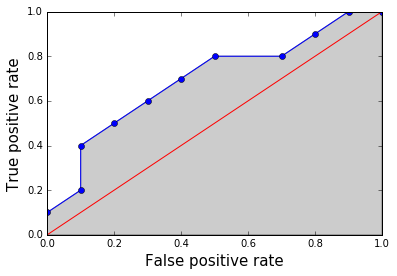

In [70]:
# applied the threshold_averaging funciton onto the above test data set
threshold_averaging(10,l2)
roc_graph(threshold_averaging(10,l2))

In [85]:
def roc_with_threshold(ROC,score):
    '''
    Helper function to attach threshold to the computed ROC curve
    Input: ROC (computed ROC points, in the order of increasing fp rate)
           score: the score array of the corresponding instances
    Output: ROC points with corresponding threshold values
    '''
    # sort the score in decreasing order
    score_ordered=score.sort_values(ascending=False)

    ROC['score']=np.r_[np.inf,score_ordered]

    return ROC

In [87]:
roc_with_threshold(points,dat_test.score).head()

,fp,tp,score
0,0.0,0.0,inf
1,0.0,0.1,0.900000
2,0.0,0.2,0.800000
3,0.1,0.2,0.700000
4,0.1,0.3,0.600000


### Optimize using cython and quantify the improvement using time

In [101]:
# import numba and time
# from numba import jit,autojit
import time
%load_ext cython

In [103]:
%%cython -a
import pandas as pd
import numpy as np
def ROC_points_cython(in_data):
    '''
    Function to generate ROC points for a bianry classifier on a given sample set with true lables and scores
    Input: a DataFrame with actual class label and scores
    Output:ROC points (tp rate, fp rate)
    '''
    ## sort the input data in descending order
    dat=in_data.sort_values(by=['score'],ascending=False)
    ## compute # of positive labels and negative labels
    P=dat.label[dat.label==1].count()
    N=dat.label[dat.label==0].count()
    
    ## initialize tp and fp to 0
    tp=0
    fp=0
    ## initialize previous score to -inf
    f_prev=-np.inf
    
    ## create an empty stack
    result=[]
    
    ## compute ROC points increasing by fp rate
    for i in range(dat.shape[0]):
        if dat.score[i]!=f_prev:
            result.append((fp/N,tp/P))
            f_prev=dat.score[i]
        if dat.label[i]==1:
            tp+=1
        else:
            fp+=1
    result.append((fp/N,tp/P))
    
    return pd.DataFrame(result,columns=['fp','tp'])

In [104]:
# compare performance

# python version
start=time.clock()
ROC1=ROC_points(dat_test)
time1=time.clock()-start

# numba version
start=time.clock()
ROC2=ROC_points_cython(dat_test)
time2=time.clock()-start

print("speed up ratio:",time1/time2)

speed up ratio: 1.8384615384612644


### vertical averaging

In [105]:
%%cython -a
import numpy as np
import pandas as pd

def INTERPOLATE_cython(ROCP1,ROCP2,X):
    '''
    Function to compute the slope for interpolation
    Input: two ROC curve points(ROCP1,ROCP2)
           X: target false postivie rate (FPR) 
    Return: The interpolated true positive rate for the given FPR
    '''
    
    slope=(ROCP2.tp-ROCP1.tp)/(ROCP2.fp-ROCP1.fp)
    return ROCP1.tp+slope*(X-ROCP1.fp)


def TPR_FOR_FPR_cython(fpr_sample,ROC,npts):
    '''
    Function to find the largest true positive rate (TPR) for a given false positive rate (FPR)
    Input: fpr_sample (false positive rate fixed)
           ROC (a set of ROC points)
           npts(number of points in ROC)
    Return: The largest TPR or the interpolated TPR for the given FPR in a ROC curve
    '''
    i=1
    while(i<npts and ROC.fp[i] <= fpr_sample):
        i+=1
    
    if ROC.fp[i-1]==fpr_sample:
        return ROC.tp[i-1]
    else:
        return INTERPOLATE_cython(ROC.ix[i-1],ROC.ix[i],fpr_sample)
    
    
def verticle_averaging_cython(sample,ROCS,*karg):
    '''
    Function to compute the verticle averaging ROC points for input points of ROC curves
    Input:sample(number of false positive samples, the number of points along the x axis of the averaged ROC curve),
          ROCS(a list of multiple ROC curves, each curve is  stored in DataFrame and has 2 components:fp and tp)
    Output: the averaged ROC points
    '''

    # create an empty array to record result
    result=[]
    # number of roc cruves
    nrocs=len(ROCS)
    
    for fpr_sample in np.arange(0,(1+1/sample),1/sample):
        tprsum=0
        for i in range(nrocs):
            tprsum+=TPR_FOR_FPR_cython(fpr_sample,ROCS[i],ROCS[i].shape[0])
        result.append((fpr_sample,tprsum/nrocs))
    #result.append((1,1))
    return pd.DataFrame(result,columns=['fp','tp'])


In [106]:
# compare performance

# python version
start=time.clock()
ROC1=verticle_averaging(10,l1)
time1=time.clock()-start

# numba version
start=time.clock()
ROC2=verticle_averaging_cython(10,l1)
time2=time.clock()-start

print("speed up ratio:",time1/time2)

speed up ratio: 1.111837862736159


### Threshold averaging

In [107]:
%%cython -a
import numpy as np
import pandas as pd

def ROC_POINT_AT_THRESHOLD_cython(ROC,thresh):
    '''
    Function to compute ROC point for a given threshold
    Input: ROC(ROC curve)
           thresh (threshold value)
    Output: ROC point at the given threshold
    '''
    
    for i in range(ROC.shape[0]):
        if ROC.score[i]<thresh:
            break    
    return ROC.ix[i]


def threshold_averaging_cython(n_sample,ROCS,*karg):
    '''
    Function to compute the average ROC points based on threshold values
    Input: n_sample(number of thresholds considered)
           ROCS(a list of ROC curves, **** BUT ***** there must be a threshold column attached in every ROC curve)
    Output: ROC points of a threshold averaging curve
    '''
    
    # creat an empty array to store result
    # result consists of a set of points on ROC curve
    result=[]
    
    
    # create an empty numpy array to store all clustering score
    score=np.empty(1)
    for points in ROCS:
        score=np.r_[score,points.score]
    # sort the score in descending order    
    score=score[np.argsort(-score)]
    
    
    for tidx in np.arange(0,len(score),int(len(score)/n_sample)):
        fprsum=0
        tprsum=0
        for ROC in ROCS:
            p=ROC_POINT_AT_THRESHOLD_cython(ROC,score[tidx])
            fprsum+=p.fp
            tprsum+=p.tp
        result.append((fprsum/len(ROCS),tprsum/len(ROCS)))
    
    return pd.DataFrame(result,columns=['fp','tp'])

In [108]:
# compare performance

# python version
start=time.clock()
ROC1=threshold_averaging(10,l2)
time1=time.clock()-start

# numba version
start=time.clock()
ROC2=threshold_averaging_cython(10,l2)
time2=time.clock()-start

print("speed up ratio:",time1/time2)

speed up ratio: 1.1346029278404564


### Application of ROC analysis 
- Apply to simulated data sets
- Apply to real data sets

In [103]:
pakinson_train = pd.read_csv('./Pakinson_data/dat.train.csv')
pakinson_train.shape

(150, 24)

In [104]:
pakinson_test = pd.read_csv('./Pakinson_data/dat.test.csv')
pakinson_test.shape

(45, 24)

In [105]:
pakinson_train.head()

,name,MDVP.Fo.Hz.,MDVP.Fhi.Hz.,MDVP.Flo.Hz.,MDVP.Jitter...,MDVP.Jitter.Abs.,MDVP.RAP,MDVP.PPQ,Jitter.DDP,MDVP.Shimmer,...,Shimmer.DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S08_3,180.198,201.249,175.456,0.00284,0.00002,0.00153,0.00166,0.00459,0.01444,...,0.02177,0.00231,26.738,1,0.403884,0.766209,-6.452058,0.212294,2.269398,0.141929
1,phon_R01_S17_2,223.365,238.987,98.664,0.00264,0.00001,0.00154,0.00151,0.00461,0.01906,...,0.03039,0.00301,26.138,0,0.447979,0.686264,-7.293801,0.086372,2.321560,0.098555
2,phon_R01_S02_2,107.332,113.840,104.315,0.00290,0.00003,0.00144,0.00182,0.00431,0.01567,...,0.02487,0.00344,26.892,1,0.637420,0.763262,-6.167603,0.183721,2.064693,0.163755
3,phon_R01_S25_3,149.689,160.368,133.608,0.00257,0.00002,0.00116,0.00134,0.00349,0.01346,...,0.01979,0.00578,27.421,1,0.365488,0.719974,-6.997403,0.210279,1.994387,0.112878
4,phon_R01_S19_2,112.014,588.518,107.024,0.00533,0.00005,0.00268,0.00329,0.00805,0.02448,...,0.04120,0.00623,24.178,1,0.509127,0.789532,-5.389129,0.306636,1.928708,0.225461


In [106]:
y_train = pakinson_train.ix[:, 'status']
X_train = pakinson_train.ix[:,1:].drop('status',axis=1)
y_test = pakinson_test.ix[:, 'status']
X_test = pakinson_test.ix[:,1:].drop('status',axis=1)

In [107]:
classifier = LogisticRegression(penalty='l1')
classifier.fit(X_train, y_train)
score = classifier.predict_proba(X_test)
score = score[:,1]

In [182]:
score

array([ 0.97962196,  0.98953734,  0.97292103,  0.87289828,  0.94904311,
        0.22418673,  0.27199002,  0.54749063,  0.56701316,  0.91757848,
        0.88541641,  0.87850081,  0.69156592,  0.81003116,  0.76134004,
        0.96542083,  0.99247129,  0.70991401,  0.97519735,  0.61148171,
        0.57001432,  0.36775935,  0.72824807,  0.77297237,  0.97565292,
        0.66231206,  0.41133192,  0.7122537 ,  0.91040734,  0.5813781 ,
        0.74365029,  0.99960042,  0.9989691 ,  0.94938279,  0.9991678 ,
        0.98805876,  0.99543308,  0.97682984,  0.99105656,  0.89558123,
        0.94167796,  0.14590948,  0.94934638,  0.6322226 ,  0.80711207])

In [108]:
ID = pakinson_test.ix[:,'name']
label = pakinson_test.ix[:,'status']
score = score
pakinson_test_roc = pd.DataFrame({'ID': ID, 'label': label, 'score':score})

In [184]:
pakinson_test_roc
pakinson_test_roc.sort_values(by=['score'],ascending=False)

,ID,label,score
31,phon_R01_S35_1,1,0.999600
34,phon_R01_S35_7,1,0.999168
32,phon_R01_S35_3,1,0.998969
36,phon_R01_S37_3,1,0.995433
16,phon_R01_S20_3,1,0.992471
38,phon_R01_S37_6,1,0.991057
1,phon_R01_S01_4,1,0.989537
35,phon_R01_S37_2,1,0.988059
0,phon_R01_S01_3,1,0.979622
37,phon_R01_S37_4,1,0.976830


In [112]:
points = ROC_points(pakinson_test_roc)
points.head()

,fp,tp
0,0.0,0.000000
1,0.0,0.025641
2,0.0,0.051282
3,0.0,0.076923
4,0.0,0.102564


In [116]:
AUC(pakinson_test_roc)

0.33974358974358976

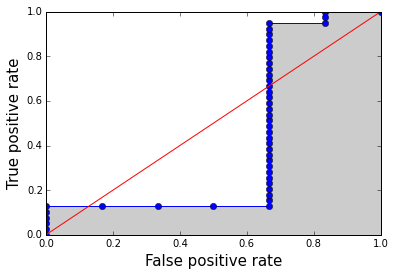

In [117]:
roc_graph(points)

Plot ROC curve, calculate auc using scikit-learn.

In [118]:
from sklearn.metrics import roc_curve, roc_auc_score

In [125]:
fpr, tpr, thres = roc_curve(np.array(label), score, pos_label=1)

In [126]:
fpr,tpr,thres

(array([ 0.        ,  0.        ,  0.16666667,  0.16666667,  0.5       ,
         0.5       ,  1.        ]),
 array([ 0.02564103,  0.64102564,  0.64102564,  0.94871795,  0.94871795,
         1.        ,  1.        ]),
 array([ 0.99960042,  0.81003116,  0.80711207,  0.57001432,  0.54749063,
         0.36775935,  0.14590948]))

In [127]:
np.array(label),score

(array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0]),
 array([ 0.97962196,  0.98953734,  0.97292103,  0.87289828,  0.94904311,
         0.22418673,  0.27199002,  0.54749063,  0.56701316,  0.91757848,
         0.88541641,  0.87850081,  0.69156592,  0.81003116,  0.76134004,
         0.96542083,  0.99247129,  0.70991401,  0.97519735,  0.61148171,
         0.57001432,  0.36775935,  0.72824807,  0.77297237,  0.97565292,
         0.66231206,  0.41133192,  0.7122537 ,  0.91040734,  0.5813781 ,
         0.74365029,  0.99960042,  0.9989691 ,  0.94938279,  0.9991678 ,
         0.98805876,  0.99543308,  0.97682984,  0.99105656,  0.89558123,
         0.94167796,  0.14590948,  0.94934638,  0.6322226 ,  0.80711207]))

In [128]:
skroc = pd.DataFrame({'fp':fpr,'tp':tpr})

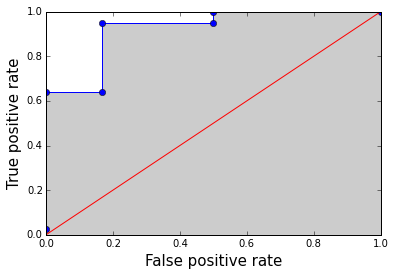

In [129]:
roc_graph(skroc)

In [130]:
roc_auc_score(label, score)

0.92307692307692313

Apply the ROC_points function, roc_graph function onto a test data set (Figure 3 in paper by Fawcett)

In [101]:
dat_test.head()

,ID,label,score
0,0,1,0.90
1,1,1,0.80
2,2,0,0.70
3,3,1,0.60
4,4,1,0.55


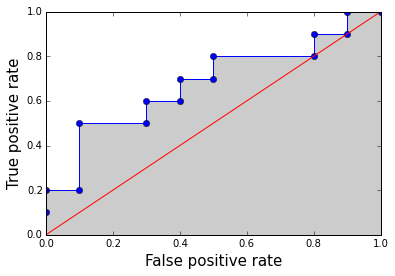

In [99]:
fpr, tpr, thres = roc_curve(dat_test['label'], dat_test['score'], pos_label=1)
skroc = pd.DataFrame({'fp':fpr,'tp':tpr})
roc_graph(skroc)

In [100]:
roc_auc_score(dat_test['label'], dat_test['score'])

0.68000000000000005

### Wrap up functions into a module

In [215]:
%%file ./ROC/ROC.py
"""

"""

def ROC_points(in_data):
    '''
    Function to generate ROC points for a bianry classifier on a given sample set with true lables and scores
    Input: a DataFrame with actual class label and scores
    Output:ROC points (tp rate, fp rate)
    '''
    
    ## sort the input data in descending order
    dat=in_data.sort_values(by=['score'],ascending=False)
    ## compute # of positive labels and negative labels
    P=dat.label[dat.label==1].count()
    N=dat.label[dat.label==0].count()
    
    ## initialize tp and fp to 0
    tp=0
    fp=0
    ## initialize previous score to -inf
    f_prev=-np.inf
    
    ## create an empty stack
    result=[]
    
    ## compute ROC points increasing by fp rate
    for i in range(dat.shape[0]):
        if dat.score[i]!=f_prev:
            result.append((fp/N,tp/P))
            f_prev=dat.score[i]
        if dat.label[i]==1:
            tp+=1
        else:
            fp+=1
    result.append((fp/N,tp/P))
    
    return pd.DataFrame(result,columns=['fp','tp'])

Overwriting ./ROC/ROC.py


In [219]:
%%file ./ROC/roc_graph.py
def roc_graph(input_rates,title=''):
    '''
    Function to plot the ROC curve and the shaded the area under the curve
    input rates: the ROC points of a classification result
    return: None, plot is generated
    '''
    # import necessary packages
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    points=input_rates
    
    fig, ax = plt.subplots()
    # plot the roc curve
    plt.plot(points.fp,points.tp,'o-')
    
    # set axis labels and title
    plt.xlabel('False positive rate',fontsize=15)
    plt.ylabel('True positive rate',fontsize=15)
    plt.title(title,fontsize=20)
    
    # shape the area under curve
    verts =  [(points.fp[0], 0)]+list(zip(points.fp,points.tp))+[(points.fp[len(points.fp)-1], 0)]
    poly = plt.Polygon(verts, facecolor='0.8', edgecolor='0.5')
    ax.add_patch(poly)
    
    # plot the 45 degree line in red
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x,'r')

Writing ./ROC/roc_graph.py


In [242]:
%%file ./ROC/AUC.py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
    
def AUC(in_data):
    '''
    Function to calculate the area under an ROC curve 
    Input: a DataFrame with actual class label and scores
    Output: A, the area under the ROC curve. 0<A<1.0 
    '''
    
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    
    ## sort the input data in descending order
    dat=in_data.sort_values(by=['score'],ascending=False)
    ## compute # of positive labels and negative labels
    P=dat.label[dat.label==1].count()
    N=dat.label[dat.label==0].count()
    
    ## initialize tp and fp to 0
    tp=0
    fp=0
    
    ## initialize previous tp and fp to -inf
    tp_prev=0
    fp_prev=0
    
    ## initialize the AUC score to 0
    A = 0
    
    ## initialize previous score to -inf
    f_prev=-np.inf
    
    ## compute ROC points increasing by fp rate
    for i in range(dat.shape[0]):
        if dat.score[i]!=f_prev:
            A += TRAPEZOID_AREA(fp,fp_prev,tp,tp_prev)
            f_prev = dat.score[i]
            fp_prev = fp
            tp_prev = tp
               
        if dat.label[i]==1:
            tp+=1
        else:
            fp+=1
    
    A = A+TRAPEZOID_AREA(N,fp_prev,N,tp_prev)
    A = A/(P*N) # scale from P · N onto the unit square
    
    return A

Overwriting ./ROC/AUC.py


In [240]:
%%file ./ROC/ROC_curve_average/__init__.py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def INTERPOLATE(ROCP1,ROCP2,X):
    '''
    Function to compute the slope for interpolation
    Input: two ROC curve points(ROCP1,ROCP2)
           X: target false postivie rate (FPR) 
    Return: The interpolated true positive rate for the given FPR
    '''
    
    slope=(ROCP2.tp-ROCP1.tp)/(ROCP2.fp-ROCP1.fp)
    return ROCP1.tp+slope*(X-ROCP1.fp)

def TPR_FOR_FPR(fpr_sample,ROC,npts):
    '''
    Function to find the largest true positive rate (TPR) for a given false positive rate (FPR)
    Input: fpr_sample (false positive rate fixed)
           ROC (a set of ROC points)
           npts(number of points in ROC)
    Output: The largest TPR or the interpolated TPR for the given FPR in a ROC curve
    '''
    i=1
    while(i<npts and ROC.fp[i] <= fpr_sample):
        i+=1
    
    if ROC.fp[i-1]==fpr_sample:
        return ROC.tp[i-1]
    else:
        return INTERPOLATE(ROC.ix[i-1],ROC.ix[i],fpr_sample)
    
def ROC_POINT_AT_THRESHOLD(ROC,thresh):
    '''
    Function to compute ROC point for a given threshold
    Input: ROC(ROC curve)
           thresh (threshold value)
    Output: ROC point at the given threshold
    '''
    
    for i in range(ROC.shape[0]):
        if ROC.score[i]<thresh:
            break    
    return ROC.ix[i]

Overwriting ./ROC/ROC_curve_average/__init__.py


In [236]:
%%file ./ROC/ROC_curve_average/vertical_average.py
def verticle_averaging(sample,ROCS,*karg):
    '''
    Function to compute the verticle averaging ROC points for input points of ROC curves
    Input:sample(number of false positive samples, the number of points along the x axis of the averaged ROC curve),
          ROCS(a list of multiple ROC curves, each curve is  stored in DataFrame and has 2 components:fp and tp)
    Output: the averaged ROC points
    '''

    # create an empty array to record result
    result=[]
    # number of roc cruves
    nrocs=len(ROCS)
    
    for fpr_sample in np.arange(0,(1+1/sample),1/sample):
        tprsum=0
        for i in range(nrocs):
            tprsum+=TPR_FOR_FPR(fpr_sample,ROCS[i],ROCS[i].shape[0])
        result.append((fpr_sample,tprsum/nrocs))
    #result.append((1,1))
    return pd.DataFrame(result,columns=['fp','tp'])

Overwriting ./ROC/ROC_curve_average/vertical_average.py


In [237]:
%%file ./ROC/ROC_curve_average/threshold_average.py
def threshold_averaging(n_sample,ROCS,*karg):
    '''
    Function to compute the average ROC points based on threshold values
    Input: n_sample(number of thresholds considered)
           ROCS(a list of ROC curves, **** BUT ***** there must be a threshold column attached in every ROC curve)
    Output: ROC points of a threshold averaging curve
    '''
    
    # creat an empty array to store result
    # result consists of a set of points on ROC curve
    result=[]
    
    
    # create an empty numpy array to store all clustering score
    score=np.empty(1)
    for points in ROCS:
        score=np.r_[score,points.score]
    # sort the score in descending order    
    score=score[np.argsort(-score)]
    
    
    for tidx in np.arange(0,len(score),int(len(score)/n_sample)):
        fprsum=0
        tprsum=0
        for ROC in ROCS:
            p=ROC_POINT_AT_THRESHOLD(ROC,score[tidx])
            fprsum+=p.fp
            tprsum+=p.tp
        result.append((fprsum/len(ROCS),tprsum/len(ROCS)))
    
    return pd.DataFrame(result,columns=['fp','tp'])

Overwriting ./ROC/ROC_curve_average/threshold_average.py


In [233]:
%%file ./ROC/__init__.py
# import necessary modules

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def TRAPEZOID_AREA(x1,x2,y1,y2):
        '''
        Function to calculate the trapezoid area  
        Input: four vertex of the trapezoid 
        Output: the area of the trapezoid
        '''
        base = abs(x1-x2)
        height = (y1+y2)/2
        return base*height

Overwriting ./ROC/__init__.py


In [243]:
from ROC.AUC import AUC
AUC(pakinson_test_roc)

NameError: name 'np' is not defined